In [1]:
import requests
from bs4 import BeautifulSoup
import re
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect, detect_langs

Decisions:
* Will just consider data form 2014 to 2021 because before that only a few districts were reporting

**TO DO**
* find coordinates
    * if cannot find locations, find random coordinates in the mentioned district
* categorize incidents:
    * attack
        (against individuals)
        * physical (or physical + verbal)
        * verbal
    * propaganda
        (against community)
        * stickers, graffiti, banners
        * speeches by individuals and members of political parties (incl. in the municipal assemblies BVV)
        * public expressions (oral and written) in media and online
    * damaging of property
        * graffiti, damaging of lgbt symbols, memorials, plaques...
    * structural discrimination
        * in workplace or public/private institutions
    * reported status to police
        * yes or no

**TO DO: MISC**
* there are four incidents without a story. Indices: [2063, 2261, 2350, 4310, 4469]
* add button to toggle language between DE and EN
* check if I can loop through found entities in doc and determine whether they are in the listed district
* terms to filter out attacks: Angriff, Attack, Aggression
    * check if I should search for lemmas instead. Do Angriff and angreifen have the same lemma?
        *I think not. So I should search for lemmas: Angriff, angreiffen, Attack, attackieren, Aggression, anschlagen, geschlagen
* desambiguate addresses when coordinates are the same 

Falsely tagged LGBT-fobic:
11687, 11773, 17192
     

# Load pickled berlin_streets_dict

In [32]:
with open('../berlin_streets_dict.pickle', 'rb') as f:
    berlin_streets_dics = pickle.load(f)

In [38]:
len(berlin_streets_dics['Straße'])

13122

# Load pickled df_complete

In [3]:
with open('pickles/df_complete.pickle', 'rb') as f:
    df_complete = pickle.load(f)

In [6]:
df_complete.loc[11041]['Story']

'An einer Hauswand in der Gerichtsstraße 14 wurde morgens die Parole “CCC Ülkücü CCC Türk Intikam Tugayi" in einer Größe von ungefähr 5 - 8 Metern entdeckt. Die drei Halbmonde “CCC” sind das Zeichen der türkischen faschistischen Gruppierung “Graue Wölfe", die sich auch als "Idealisten" ("Ülkücü")-Bewegung bezeichnen. "Türk Intikam Tugayi" bedeutet "Nationale Türkische Rachebrigade”.'

# Load pickled df_lgbt

In [57]:
with open('df_lgbt.pickle', 'rb') as f:
    df_lgbt = pickle.load(f)

In [5]:
df_complete

,Date,District,Header,Story,Source,ID,Link
0,2007-12-29,Treptow-Köpenick,Sachbeschädigung an Parteibüro in Niederschöne...,Im Wahlkreisbüro der Partei Die Linke in der B...,Pressemitteilung der Polizei,19439.0,https://berliner-register.de/vorfall/treptow-k...
1,2007-12-20,Treptow-Köpenick,Verkaufsstand eines rechten Modelabels in Köpe...,Am S-Bahnhof Köpenick auf dem Markt stand ein ...,Antifaschistisches Bündnis Süd-Ost,19438.0,https://berliner-register.de/vorfall/treptow-k...
2,2007-12-19,Treptow-Köpenick,Rassistische strukturelle Benachteiligung in A...,Beamte der Bundespolizei kontrollierten am S-B...,Antifaschistisches Bündnis Süd-Ost,19437.0,https://berliner-register.de/vorfall/treptow-k...
3,2007-12-13,Treptow-Köpenick,Flyer gegen politische Gegner*innen in der BVV,Auf die Plätze einer Abgeordneten der Linkspar...,Die LINKE,19436.0,https://berliner-register.de/vorfall/treptow-k...
4,2007-12-08,Treptow-Köpenick,NS-verherrlichende Propaganda in Johannisthal,In der Südostallee und im Sterndamm wurden ein...,Treptower Antifa Gruppe,19435.0,https://berliner-register.de/vorfall/treptow-k...
...,...,...,...,...,...,...,...
21983,2021-01-02,Reinickendorf,Schriftzug gegen politische Gegner:innen in Tegel,Auf einem Mülleimer in Alt-Tegel wurde der Sch...,Meldung einer Einzelperson,21820.0,https://berliner-register.de/vorfall/reinicken...
21984,2021-01-01,Treptow-Köpenick,Aufkleber des neonazistischen 3. Weg in Köpeni...,In der Kaulsdorfer Str. nähe Bahrendorfer Str....,Zentrum für Demokratie,20057.0,https://berliner-register.de/vorfall/treptow-k...
21985,2021-01-01,Treptow-Köpenick,Hakenkreuze in Friedrichshagen,In der Dörpfeldstr. zwischen Bhf. Friedrichsha...,Zentrum für Demokratie,20060.0,https://berliner-register.de/vorfall/treptow-k...
21986,2021-01-01,Lichtenberg,Bedrohung gegen politische*n Gegner*in in Lich...,In der Nacht zum 1.1.2021 wurde ein Mensch im ...,Lichtenberger Register,20896.0,https://berliner-register.de/vorfall/lichtenbe...


# Select df

In [55]:
# Only cases between 2014 and 2021
df_2014_2021 = df_complete[df_complete['Date'].dt.year >= 2014][['Date', 'District', 'Header', 'Story', 'Source']]
df_2014_2021.shape

(20360, 5)

In [61]:
# only cases that mention violence against LGBTQI* people in header OR in story
lgbt_lexicon = 'heteronormativ|gay|lgbt|lgtb|lbgt|ltgb|lgbqt|schwul|schwuchtel|lsbt|transgender|'\
'transphob|transsex|transfrau|transperson|transmann|transfeind|homophob|queer|gleichgeschlecht|'\
'homosexu|homofeindlich|sexuelle[rn]* [ovi]|[^a-zöäüß]gender|binär'

df_lgbt = df_2014_2021[(df_2014_2021['Story'].str.contains(lgbt_lexicon, flags=re.IGNORECASE) == True)|(df_2014_2021['Header'].str.contains(lgbt_lexicon, flags=re.IGNORECASE) == True)]

In [538]:
# lenght of DataFrame and TODO number of characters to translate afterwards
len(df_lgbt), df_lgbt['Story'].str.len().sum(), df_lgbt['Header'].str.len().sum()

(1009, 398536, 45913)

In [62]:
lgbt_indices = df_lgbt.index

In [540]:
# Test for LGBT words
test_term = 'binär'
test_indices = df_2014_2021[(df_2014_2021['Story'].str.contains(test_term, flags=re.IGNORECASE) == True)|(df_2014_2021['Header'].str.contains(test_term, flags=re.IGNORECASE) == True)].index
a=np.array([x for x in np.array(test_indices) if x not in np.array(lgbt_indices)])
a
#geschlechterbild -konzept #binären

array([], dtype=float64)

In [530]:
df_2014_2021.loc[a]['Header']


15857          Online-Monitoring: April  
17131       Erneut NPD-Aufkleber am Corso
17610    NPD-Aufkleber in Hellersdorf-Süd
Name: Header, dtype: object

In [541]:
df_2014_2021.loc[17610]['Story']


'An einem Briefkasten in der Neuen Grottkauer Straße wurde ein NPD-Aufkleber gefunden und entfernt. Der Aufkleber propagiert ein rein binäres Geschlechterbild.'

### Fill missing values

In [551]:
df_lgbt[df_lgbt['District'].isna() == True]

,Date,District,Header,Story,Source
2421,2014-04-29,NaN,LGBQT feindlicher Angriff in der Beusselstraße,Ein 23- und ein 28-jähriger Mann werden gegen ...,Reach Out
4512,2015-02-24,NaN,Treffen der Jungen Alternative im Europa-Center,Am 24. Februar 2015 veranstaltete zum Thema Ha...,"Register CW, Facebook"


In [565]:
df_lgbt[df_lgbt['District'].isna() == True]
# df_lgbt['District'].loc[4512] = 'Charlottenburg-Wilmersdorf'
# df_lgbt['District'].loc[2421] = 'Mitte'

,Date,District,Header,Story,Source


In [639]:
# pickle df_lgbt
with open('df_lgbt.pickle', 'wb') as f:
    pickle.dump(df_lgbt, f)

# Add classifiers

In [587]:
# Add columns with np.nan
df_lgbt['Reported status'] = [np.nan for x in range(len(df_lgbt))]

<ipython-input-587-39245ea6712c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lgbt['Reported status'] = [np.nan for x in range(len(df_lgbt))]


**Physical Attack**

In [620]:
filter_words = 'angriff|attack'
df_physical_attacks = df_lgbt[(df_lgbt['Header'].str.contains(filter_words, flags=re.IGNORECASE) == True)|(df_lgbt['Story'].str.contains(filter_words, flags=re.IGNORECASE) == True)]

In [634]:
physical_attack_indices = df_physical_attacks.index
physical_attack_indices

Int64Index([ 1707,  1836,  1940,  1951,  2194,  2254,  2255,  2327,  2421,
             2581,
            ...
            20341, 20354, 20389, 20606, 20672, 20733, 20735, 20746, 20824,
            21263],
           dtype='int64', length=375)

In [623]:
for i in attack_indices:
    df_lgbt.loc[i, 'Attack'] = 'physical'

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


**Verbal Attack**

In [630]:
df_without_physical_attacks = (df_lgbt[df_lgbt['Attack'].isna() == True])

In [632]:
filter_words = 'beleidig|beschimpf|bedroh'
df_verbal_attacks = df_without_physical_attacks[(df_without_physical_attacks['Header'].str.contains(filter_words, flags=re.IGNORECASE) == True)|(df_without_physical_attacks['Story'].str.contains(filter_words, flags=re.IGNORECASE) == True)]

In [633]:
# get indices
verbal_attack_indices = df_verbal_attacks.index
verbal_attack_indices

Int64Index([ 1874,  2063,  2126,  2151,  2227,  2260,  2261,  2275,  2335,
             2340,
            ...
            21127, 21193, 21206, 21215, 21321, 21416, 21459, 21900, 21948,
            21974],
           dtype='int64', length=260)

In [635]:
for i in verbal_attack_indices:
    df_lgbt.loc[i, 'Attack'] = 'verbal'

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [654]:
df_lgbt_test = df_lgbt[['Date', 'District', 'Header', 'Story', 'Source', 'Attack']]
df_lgbt_attacks = df_lgbt_test.dropna()

In [656]:
# pickle df_lgbt_attacks
with open('df_lgbt_attacks.pickle', 'wb') as f:
    pickle.dump(df_lgbt_attacks, f)

### Add coordinates

In [569]:
from geopy.geocoders import Nominatim

In [570]:
loc = Nominatim(user_agent="mymap").geocode("europacenter")
loc.address

'Europacenter, Tauentzienstraße, Charlottenburg, Charlottenburg-Wilmersdorf, Berlin, 10789, Deutschland'

In [571]:
coord = loc.latitude, loc.longitude
coord

(52.5044473, 13.3365729)

In [ ]:
df_2014_2021_attacks[df_2014_2021_attacks['Story'].str.contains(lgbt_lexicon, flags=re.IGNORECASE) == True]


In [463]:
df_2020_monthly_district = df_2020.groupby(['District', df_complete['Date'].dt.month])[['Header']].count().unstack('District')

In [464]:
df_2020_monthly_district

Header                                                      \
District Berlinweit Charlottenburg-Wilmersdorf Friedrichshain-Kreuzberg   
Date                                                                      
1                54                         34                       24   
2                45                         19                       21   
3                15                         29                       19   
4                41                         15                       19   
5                49                         27                       35   
6                52                         14                       38   
7                91                         19                       37   
8                76                         23                       32   
9                48                         26                       35   
10               62                         26                       26   
11               63                         26                       32   
12               35                         19                       29   

                                                                              \
District Lichtenberg Marzahn-Hellersdorf Mitte Neukölln Pankow Reinickendorf   
Date                                                                           
1                 18                  23    34        8     18             8   
2                 14                  15    29       24     14             2   
3                 24                  31    34       13     25             6   
4                 22                  29    39       17     14             9   
5                 38                  22    61       24     36             7   
6                 38                  32    60       30     19             9   
7                 29                  15    46       25      8             6   
8                 45                  18    68       18     23            13   
9                 46                  23    60       14     17             7   
10                48                  10    81       20     28            10   
11                47                  25    52       25     28            10   
12                52                  10    45       18     18            11   

                                                                            
District Spandau Steglitz-Zehlendorf Tempelhof-Schöneberg Treptow-Köpenick  
Date                                                                        
1              6                  12                   12               24  
2              6                  19                   10               30  
3             12                   9                   12               15  
4              2                  16                    7               34  
5              6                  12                   10               27  
6             10                  11                   13               27  
7             11                  13                   16               24  
8             14                  15                    5               25  
9              5                  10                   14               29  
10            11                   7                   10               31  
11            12                  10                   12               33  
12             3                  13                   11               31

<AxesSubplot:xlabel='month', ylabel='reported cases'>

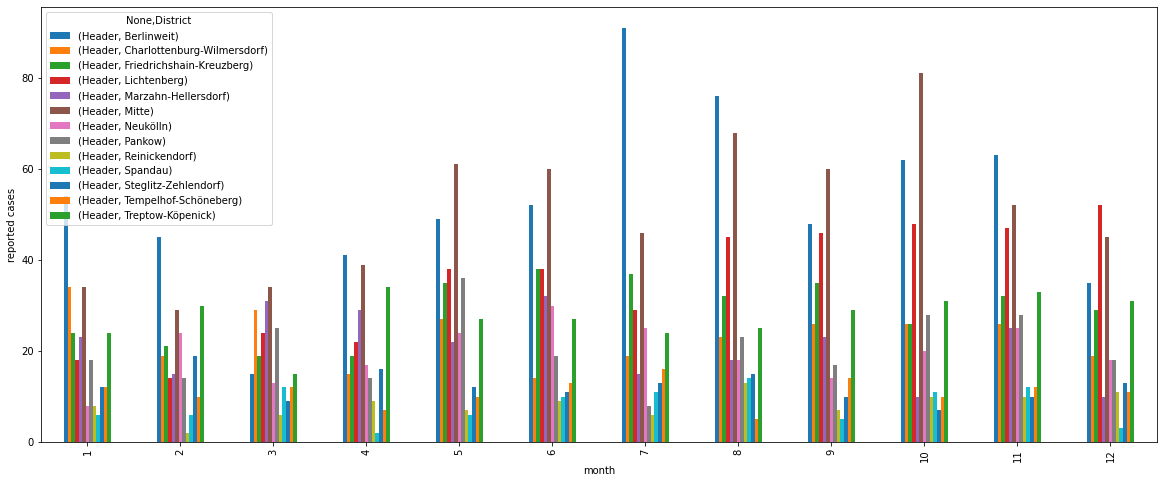

In [465]:
df_2020_monthly_district.plot(figsize=(20,8), kind='bar', xlabel='month', ylabel='reported cases')

In [466]:
df_2014_2021 = df_complete[df_complete['Date'].dt.year >= 2014][['Date', 'District', 'Header', 'Source']]

In [469]:
df_2014_2021_yearly_district = df_2014_2021.groupby(['District', df_complete['Date'].dt.year])[['Header']].count().unstack('District')
df_2014_2021_yearly_district


Header                                                      \
District Berlinweit Charlottenburg-Wilmersdorf Friedrichshain-Kreuzberg   
Date                                                                      
2014            NaN                      105.0                    179.0   
2015            NaN                      183.0                    173.0   
2016            NaN                      231.0                    132.0   
2017          263.0                      246.0                    178.0   
2018          460.0                      282.0                    244.0   
2019          374.0                      243.0                    270.0   
2020          631.0                      277.0                    347.0   
2021            3.0                       63.0                    151.0   

                                                                               \
District Lichtenberg Marzahn-Hellersdorf  Mitte Neukölln Pankow Reinickendorf   
Date                                                                            
2014           105.0                84.0   79.0    126.0  167.0           4.0   
2015           228.0               298.0  197.0    149.0  243.0          32.0   
2016           334.0               354.0  283.0    265.0  229.0          76.0   
2017           273.0               187.0  345.0    269.0  230.0         113.0   
2018           210.0               182.0  496.0    364.0  235.0         117.0   
2019           258.0               154.0  646.0    204.0  236.0         107.0   
2020           421.0               253.0  609.0    236.0  248.0          98.0   
2021           326.0                53.0  189.0     93.0  124.0          19.0   

                                                                            
District Spandau Steglitz-Zehlendorf Tempelhof-Schöneberg Treptow-Köpenick  
Date                                                                        
2014        18.0                 NaN                 35.0            227.0  
2015        39.0                 6.0                 82.0            305.0  
2016        52.0               248.0                120.0            367.0  
2017        76.0               236.0                100.0            311.0  
2018        80.0               222.0                 94.0            448.0  
2019        94.0               179.0                126.0            324.0  
2020        98.0               147.0                132.0            330.0  
2021         9.0                22.0                 43.0            153.0

<AxesSubplot:xlabel='year', ylabel='reported cases'>

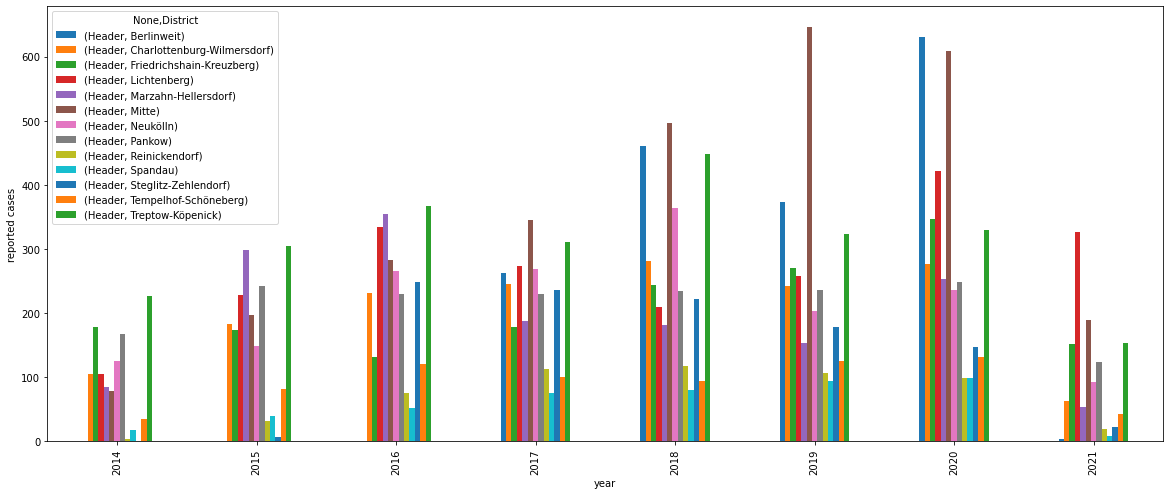

In [470]:
df_2014_2021_yearly_district.plot(figsize=(20,8), kind='bar', xlabel='year', ylabel='reported cases')

In [533]:
df_attacks_2014_2021 = df_2014_2021[df_2014_2021['Header'].str.contains('angriff|attack|beleidig|beschimpf|bedroh', flags=re.IGNORECASE) == True]


In [534]:
df_attacks_2014_2021

,Date,District,Header,Source,Story
1638,2014-12-23,Mitte,Rassistischer Angriff in der U-Bahn,"ReachOut, Polizei",In der U-Bahn der Linie 8 auf Höhe des U-Bahnh...
1661,2014-12-13,Charlottenburg-Wilmersdorf,Rassistischer Angriff in Schmargendorf,"Polizei Berlin (Nachmeldung des LKA), ReachOut",Am 13. Dezember 2014 um 17.10 Uhr wird ein Man...
1662,2014-12-13,Charlottenburg-Wilmersdorf,Angriff in der S-Bahn,ReachOut Berlin,"Ein Mann, der sich am 13. Dezember 2014 auf de..."
1687,2014-12-05,Treptow-Köpenick,Angriff auf Antirassist*innen,Uffmucken,Teilnehmende einer antirassistischen Demonstra...
1692,2014-12-02,Pankow,"Beleidigung, „Heil Hitler“-Ruf und Hitlergruß",Anwohner*in,Am späten Nachmittag beleidigte ein stark alko...
...,...,...,...,...,...
21924,2021-01-12,Charlottenburg-Wilmersdorf,Rassistisch motivierter Angriff in Halensee,Register CW,In der Nedlitzerstraße in Halensee wurde eine ...
21947,2021-01-07,Treptow-Köpenick,Rassistische Beleidigung in Johannisthal,Pressemitteilung der Polizei,Am Mittag beleidigte ein Autofahrer während ei...
21948,2021-01-07,Mitte,Homophobe Beleidigung und Bedrohung im U-Bahnh...,"Registerstelle Mitte, Twitter",Im U-Bahnhof Seestraße wurde gegen 8.20 Uhr ei...
21955,2021-01-06,Neukölln,Rassistische Beleidigung bei Einzug an der Son...,Register Neukölln,Als eine Person auf der Höhe des Hertzbergplat...


In [492]:
df_attacks_2014_2021_yearly_district =  df_attacks_2014_2021.groupby(['District', df_complete['Date'].dt.year])[['Header']].count().unstack('District')
df_attacks_2014_2021_yearly_district


Header                                                      \
District Berlinweit Charlottenburg-Wilmersdorf Friedrichshain-Kreuzberg   
Date                                                                      
2014            NaN                       14.0                      9.0   
2015            NaN                       18.0                     10.0   
2016            NaN                       22.0                     15.0   
2017            1.0                       14.0                     10.0   
2018            NaN                       16.0                     24.0   
2019            3.0                       15.0                     17.0   
2020            1.0                       22.0                     24.0   
2021            NaN                        3.0                      9.0   

                                                                              \
District Lichtenberg Marzahn-Hellersdorf Mitte Neukölln Pankow Reinickendorf   
Date                                                                           
2014             4.0                 8.0  17.0      NaN    6.0           NaN   
2015            12.0                39.0  19.0      3.0   17.0           7.0   
2016            20.0                23.0  40.0      4.0   17.0           7.0   
2017            15.0                18.0  41.0     12.0    8.0          11.0   
2018            20.0                 5.0  47.0     14.0   19.0          12.0   
2019            26.0                12.0  78.0     48.0   14.0           9.0   
2020            23.0                11.0  43.0     28.0   25.0          14.0   
2021             7.0                 2.0   8.0      3.0    NaN           NaN   

                                                                            
District Spandau Steglitz-Zehlendorf Tempelhof-Schöneberg Treptow-Köpenick  
Date                                                                        
2014         2.0                 NaN                 11.0              6.0  
2015         3.0                 1.0                 15.0              4.0  
2016         3.0                 9.0                 11.0              3.0  
2017         1.0                 3.0                 15.0              5.0  
2018         7.0                 6.0                 15.0             20.0  
2019         6.0                 9.0                 27.0             26.0  
2020        19.0                 6.0                 16.0             21.0  
2021         1.0                 1.0                  1.0              5.0

<AxesSubplot:xlabel='year', ylabel='reported cases'>

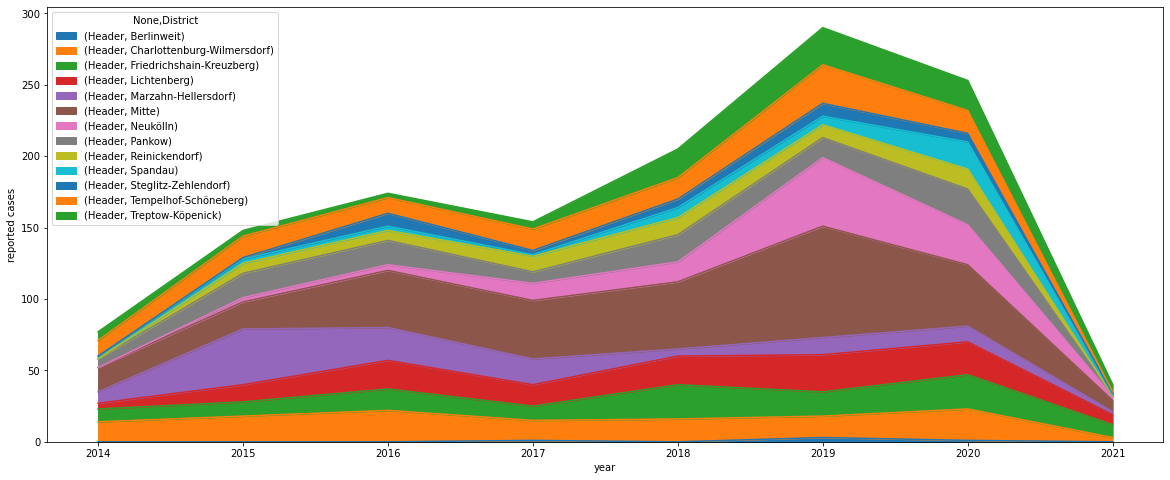

In [498]:
df_attacks_2014_2021_yearly_district.plot(figsize=(20,8), kind='area', xlabel='year', ylabel='reported cases')

In [499]:
df_attacks_2014_2021_monthly_district =  df_attacks_2014_2021.groupby(['District', df_complete['Date'].dt.month])[['Header']].count().unstack('District')
df_attacks_2014_2021_monthly_district


Header                                                      \
District Berlinweit Charlottenburg-Wilmersdorf Friedrichshain-Kreuzberg   
Date                                                                      
1               NaN                       12.0                      5.0   
2               1.0                        3.0                      9.0   
3               NaN                       13.0                      7.0   
4               NaN                       18.0                      8.0   
5               NaN                       12.0                     20.0   
6               1.0                       13.0                     16.0   
7               NaN                       15.0                     11.0   
8               2.0                       12.0                     11.0   
9               NaN                        8.0                     11.0   
10              1.0                        8.0                      7.0   
11              NaN                        5.0                      5.0   
12              NaN                        5.0                      8.0   

                                                                              \
District Lichtenberg Marzahn-Hellersdorf Mitte Neukölln Pankow Reinickendorf   
Date                                                                           
1                8.0                11.0  20.0      5.0    4.0           7.0   
2               14.0                12.0  15.0     14.0    5.0           4.0   
3                9.0                14.0  33.0      7.0    6.0           8.0   
4               15.0                 8.0  21.0      8.0    7.0           3.0   
5               13.0                11.0  30.0      9.0   15.0           5.0   
6                9.0                 9.0  28.0     13.0   10.0           7.0   
7               10.0                12.0  30.0     12.0    6.0           4.0   
8               12.0                 6.0  31.0     12.0   16.0           7.0   
9               12.0                 9.0  27.0     12.0   12.0           3.0   
10              11.0                 8.0  26.0      6.0    9.0           4.0   
11               5.0                12.0  20.0      8.0   12.0           4.0   
12               9.0                 6.0  12.0      6.0    4.0           4.0   

                                                                            
District Spandau Steglitz-Zehlendorf Tempelhof-Schöneberg Treptow-Köpenick  
Date                                                                        
1            2.0                 4.0                  6.0              3.0  
2            1.0                 2.0                  7.0              4.0  
3            5.0                 4.0                 10.0              9.0  
4            2.0                 2.0                 13.0              5.0  
5            2.0                 3.0                 13.0             12.0  
6            2.0                 5.0                 12.0             14.0  
7            7.0                 3.0                  8.0              8.0  
8            6.0                 2.0                  4.0             15.0  
9            5.0                 3.0                 14.0              2.0  
10           3.0                 4.0                  9.0              9.0  
11           4.0                 2.0                  8.0              3.0  
12           3.0                 1.0                  7.0              6.0

<AxesSubplot:xlabel='month', ylabel='reported cases'>

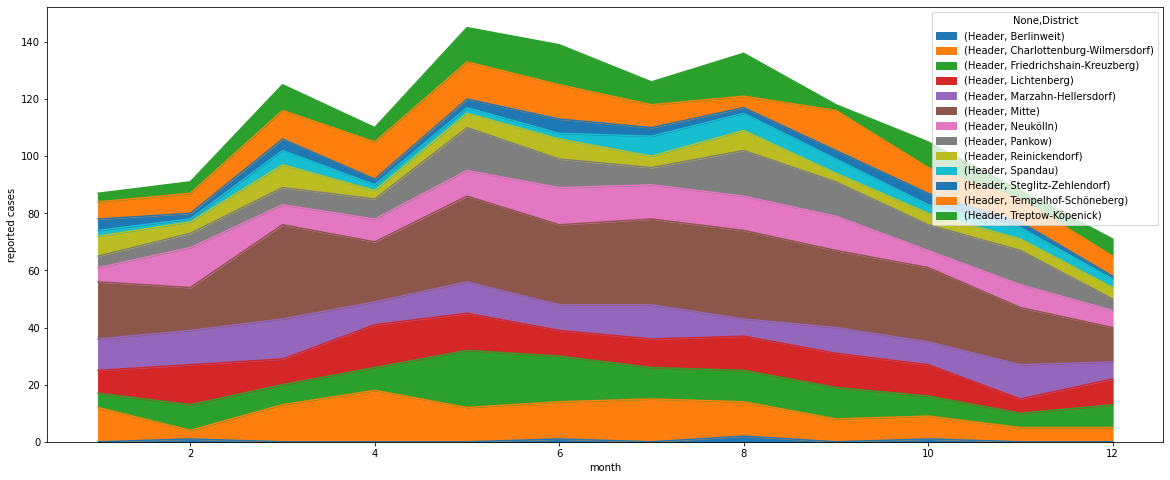

In [500]:
df_attacks_2014_2021_monthly_district.plot(figsize=(20,8), kind='area', xlabel='month', ylabel='reported cases')

In [505]:
df_2014_2021 = df_complete[df_complete['Date'].dt.year >= 2014][['Date', 'District', 'Header', 'Source', 'Story']]

In [633]:
df_2014_2021_attacks = df_2014_2021[df_2014_2021['Header'].str.contains('angriff|attack|beleidig|beschimpf', flags=re.IGNORECASE) == True]

In [634]:
df_2014_2021_attacks.shape

(2875, 5)

In [644]:
df_2014_2021_lgbt_attacks = df_2014_2021_attacks[df_2014_2021_attacks['Story'].str.contains('gay|lgbt|lgtb|schwul|lsbt|transphob|transsex|transfrau|transmann|transfeindlich|homophob|gleichgeschlecht', flags=re.IGNORECASE) == True]


In [645]:
df_2014_2021_lgbt_attacks.shape

(457, 5)

In [559]:
df_2014_2021.loc[20746]['Story']

'Zwei Männer wurden von einer Gruppe Jugendlicher nach einem Streitgespräch LGTBIQ*-feindlich beledigt.\nNachdem die beiden beleidigt worden waren, entblößte einer aus der Gruppe Jugendlicher seinen Genitalbereich. Anschließend wurden beide Männer mit Schlägen gegen den Kopf attackiert und dabei verletzt.'

In [557]:
df_2014_2021[df_2014_2021['Date'] == "2021-05-29"]

,Date,District,Header,Source,Story
20745,2021-05-29,Pankow,NPD-Aufkleber in S-Bahn,NEA (Antifa-Nordost),In der S-Bahn S8 wurden auf Höhe Schönhauser A...
20746,2021-05-29,Neukölln,LGBTIQ*-feindlicher Angriff auf der Sonnenallee,"Register Neukölln, Polizeimeldung Nr. 1173",Zwei Männer wurden von einer Gruppe Jugendlich...
20747,2021-05-29,Mitte,Anti-asiatischer Rassismus im Bus,"Berliner Register, Twitter",In einem Bus der Linie 106 vom Südkreuz nach W...


In [562]:
df_2014_2021_lgbt_attacks.shape

(394, 5)

### Add District (Mitte) to missing value index= 2421

In [583]:
df_2014_2021_lgbt_attacks[df_2014_2021_lgbt_attacks['District'].isna() == True]['Story'].iloc[0]

'Ein 23- und ein 28-jähriger Mann werden gegen 22.40 Uhr in der Beusselstraße von mehreren Personen homophob beleidigt und mit Flaschen beworfen. Der 28-jährige wird von einer Person getreten, kann aber fliehen. Der 23-Jährige wird getreten und geschlagen und ihm wird ein Messer an den Hals gehalten. Die Gruppe flüchtet, als die Polizei, die der 28-Jährige inzwischen alarmiert hat, kommt. Die Polizei kann später einen 40-jährigen Täter ermitteln.'

In [591]:
df_2014_2021_lgbt_attacks[df_2014_2021_lgbt_attacks['District'].isna() == True]

,Date,District,Header,Source,Story
2421,2014-04-29,NaN,LGBQT feindlicher Angriff in der Beusselstraße,Reach Out,Ein 23- und ein 28-jähriger Mann werden gegen ...


In [592]:
df_2014_2021_lgbt_attacks.loc[2421, 'District'] = 'Mitte'

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [593]:
df_2014_2021_lgbt_attacks.loc[2421]

Date                                      2014-04-29 00:00:00
District                                                Mitte
Header        LGBQT feindlicher Angriff in der Beusselstraße 
Source                                              Reach Out
Story       Ein 23- und ein 28-jähriger Mann werden gegen ...
Name: 2421, dtype: object

In [563]:
df_2014_2021_lgbt_attacks.iloc[-100:-50]

,Date,District,Header,Source,Story
16650,2019-02-06,Neukölln,LGTIQ*-feindlicher Angriff in Britz,ReachOut Berlin,In der Backbergstraße wurde ein 68-jähriger Ma...
16659,2019-02-05,Mitte,LGBTIQ-feindlicher Angriff in Gesundbrunnen,"ReachOut, Polizei Berlin vom 11.07.2019",Ein 47-jähriger Mann wird gegen 22.10 Uhr vor ...
16901,2019-01-01,Mitte,Homophober Angriff in einem Lokal am Alexander...,Polizeimeldung Nr. 0013 vom 01.01.2019,In einem Lokal am Alexanderplatz kam es am frü...
16905,2019-01-01,Neukölln,Transfeindlicher Angriff in Nordneukölln,ReachOut Berlin,Gegen 18 Uhr wurde eine unbekannte Transfrau i...
17031,2020-12-19,Steglitz-Zehlendorf,LGBTIQ*feindlicher Angriff in Nikolassee,ReachOut Berlin,Gegen 20.35 Uhr wird ein 34-jähriger Mann in d...
17039,2020-12-18,Mitte,Homophobe Beleidigung und Bedrohung im Wedding,Registerstelle Mitte,In der Kiautschoustraße im Wedding wurde gegen...
17061,2020-12-15,Neukölln,Transfeindliche Beleidigung auf Karl-Marx-Str.,Register Neukölln,An der Karl-Marx-Straße wurde eine als transge...
17253,2020-11-28,Mitte,LGBTIQ*feindlicher Angriff in Moabit,ReachOut Berlin,Gegen 18.00 Uhr wurde ein 29-jähriger Mann in ...
17329,2020-11-21,Marzahn-Hellersdorf,LGBTIQ*-feindlicher Angriff in Mahlsdorf,ReachOut,Zwei Männer und eine Frau wurden am Abend auf ...
17444,2020-11-12,Neukölln,LGBTIQ*-feindlicher Angriff,ReachOut,Ein 26-jähriger Mann wird gegen 18 Uhr in der ...


In [545]:
df_2014_2021_lgbt_attacks.iloc[-3]['Story']

'Zeug*innen haben am U-Bahn-Ausgang Kottbusser Tor beobachtet, wie eine festgenommene Person of Colour von mehreren Polizist*innen in zivil und Uniform zum Einsatzwagen verbracht wurde. Die Person wurde mit dem Gesicht gegen das Fahrzeug gedrückt und war von sechs Beamt*innen umgeben, von denen einer keine Maske und einer sie nur unter der Nase trug. Als einer der Zeug*innen die festgenommene Person fragte, ob sie Unterstützung bräuchte, wurde sie mehrmals sehr stark von zwei Polizisten gestoßen, besonders von dem ohne Maske. Auch die zweite Zeugin wurde weggestoßen. Die Zeug*innen beriefen sich auf ihr Recht, in gebürendem Abstand zu beobachten und forderten die Polizisten auf, die Mund-Nasen-Bedeckung vorschriftsmäßig zu tragen, da sie die Gesundheit der festgenommenen Person gefährdeten. Unter Murren setzten sie die Masken ordentlich auf. Die festgenommene Person wurde in Handschellen zu einem anderen Einsatzwagen verbracht und abtransportiert. Der Festgenommene war die ganze Zeit ü

In [614]:
# Olympia & Cheryl attach
df_2014_2021_lgbt_attacks[df_2014_2021_lgbt_attacks['District'] == 'Neukölln'][df_2014_2021_lgbt_attacks['Date'] == '2020-04-12']['Story'].iloc[0]

<ipython-input-614-241ff01241a7>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2014_2021_lgbt_attacks[df_2014_2021_lgbt_attacks['District'] == 'Neukölln'][df_2014_2021_lgbt_attacks['Date'] == '2020-04-12']['Story'].iloc[0]


'Zwei Personen wurden Nachts von einem Mann aus transfeindlicher Motivation heraus angegriffen.\nDer Mann schlug einer der beiden Personen zwei Mal mit der Faust ins Gesicht und flüchtete anschließend.'

## Check for references to Turks or Arabs

In [647]:
df_2014_2021_lgbt_attacks[df_2014_2021_lgbt_attacks['Story'].str.contains('arab|turk') == True]['Date']

5903    2016-07-14
9675    2017-03-30
11789   2018-07-20
18817   2020-07-17
Name: Date, dtype: datetime64[ns]

In [651]:
df_2014_2021_lgbt_attacks[df_2014_2021_lgbt_attacks['Date'].dt.year == 2018]

,Date,District,Header,Source,Story
10272,2018-12-31,Mitte,Homophober Angriff im Wedding,Opferhilfe e.V.,Ein Mann wurde im Wedding auf offener Straße h...
10294,2018-12-25,Neukölln,LGBTIQ-feindlicher Angriff in Nordneukölln,"Polizei Berlin, Polizeimeldung Nr. 2694",Ein 25-Jähriger war gegen 15 Uhr in Begleitung...
10320,2018-12-18,Friedrichshain-Kreuzberg,Transfeindliche Beleidigung in Kreuzberg,Bürger_Innen-Meldung,Eine junge Frau beleidigte in den Mehringhöfen...
10340,2018-12-15,Treptow-Köpenick,LGBTIQ*-feindlicher Angriff in der Köpenicker ...,ReachOut,Ein 14-jähriger Jugendlicher wurde gegen 19.10...
10399,2018-12-06,Pankow,Rassitischer Angriff in Prenzlauer Berg,ReachOut,Im Ortsteil Prenzlauer Berg wird in der Storko...
...,...,...,...,...,...
13371,2018-02-12,Mitte,Homophober Angriff,Register Berlin-Mitte,Gegen 20 Uhr wurde ein männliches Paar beim Ve...
13425,2018-02-04,Neukölln,Homophober Angriff am Hermannplatz,"Polizei Berlin, Polizeimeldung Nr. 0291",Gegen 0.30 Uhr wurde ein 28-Jähriger aus einer...
13477,2018-01-30,Friedrichshain-Kreuzberg,"Mann in der Skalitzer Straße beleidigt, geschl...",ReachOut Berlin,Gegen 5.25 Uhr wird ein 30-jähriger Mann in de...
13551,2018-01-20,Friedrichshain-Kreuzberg,Frauen in der Boxhagener Straße beleidigt und ...,ReachOut Berlin,Eine 27-jährige und eine 29-jährige Frau werde...


In [653]:
df_2014_2021.loc[10294]['Story']

'Ein 25-Jähriger war gegen 15 Uhr in Begleitung seines Freundes in der Weserstraße unterwegs, als er von drei Unbekannten LGBTIQ-feindlich beschimpft wurde. Außerdem versuchte ein Mann aus der Dreiergruppe, den 25-Jährigen zu schlagen. Die Attacke wurde jedoch von den anderen beiden Unbekannten des Trios verhindert.'

### Detect languages and find missing stories in df_complete

All stories in German. Some include text in English too.

In [27]:
list(df_complete['Story']

'Im Wahlkreisbüro der Partei Die Linke in der Brückenstraße wurden zwei Fensterscheiben eingeworfen und ein Handzettel aus der Neonaziszene hinterlassen.'

In [29]:
stories = list(df_complete['Story'])
languages_stories = []
missing_stories = [] # index of missing stories in LIST stories
for i, story in enumerate(stories):
    try:
        lan = detect(story)
    except:
        lan = np.nan
        missing_stories.append(i)
    languages_stories.append(lan)

In [39]:
set(languages_stories)

{'de', 'en', nan, 'nl'}

In [54]:
# indices of stories in en, nl and missing 
indices_en = [i for i, x in enumerate(languages_stories) if x == "en"]
indices_nl = [i for i, x in enumerate(languages_stories) if x == "nl"]
indices_nan = [i for i, x in enumerate(languages_stories) if type(x) != str]

---

## Scrape data

In [92]:
def scrape_links():
    '''
    Scrapes links of all the cases registered 
    '''
    years = [x for x in range(2007, 2022)]
    links_cases = []
    titles_cases = []
    for year in years:
        path = f'https://berliner-register.de/chronik?field_datum_value%5Bvalue%5D%5Byear%5D={year}'
        response = requests.get(path)
        chronik_list_html = response.text
        chronik_list_soup = BeautifulSoup(chronik_list_html)#, features="lxml")
        html_links = chronik_list_soup.find_all(attrs={'class': 'views-field views-field-title'})
        for i in html_links:
            str_entry = str(i.find_all('a')[0])
            path_end, case_title = re.findall('(\/.+)">(.+)<', str_entry)[0]
            path = 'https://berliner-register.de' + path_end
            links_cases.append(path)
            titles_cases.append(case_title)
    return links_cases

In [167]:
# pickled links_cases: list of all links
with open('links_cases.pickle', 'wb') as f:
    pickle.dump(links_cases, f)

In [281]:
def make_cases_dict():
    cases_dict = {'Date': [], 'District': [], 'Header': [], 'Story': [], 'Source': [], 'ID': [], 'Link': []}
    for path in links_cases:
        try:
            case_id = int(re.findall('\d+$', path)[0])
        except:
            case_id = np.nan
        response = requests.get(path)
        case_html = response.text
        case_soup = BeautifulSoup(case_html).find(attrs={'id': 'main'})
        case_title = case_soup.h1.text
        try:
            case_description_soup = case_soup.find_all('p')
            # makes sure all paragraphs are extracted
            case_description_list = [x.text for x in case_description_soup]
            case_description = '\n'.join(case_description_list)
        except:
            case_description = np.nan
        try:
            case_bezirk = case_soup.find(attrs={
                'class': "field field-name-field-register-vorfall field-type-taxonomy-term-reference field-label-inline clearfix"}).find(attrs={
                'class': 'field-item even'
            }).text
        except:
            case_bezirk = np.nan
        try:
            case_date = case_soup.find(attrs={
                'class': 'field field-name-field-datum field-type-datetime field-label-inline clearfix'
            }).find(attrs={'class': 'field-item even'}).text
        except:
            case_date = np.nan
        try:
            case_source = case_soup.find(attrs={
                'class': 'field field-name-field-quelle field-type-text field-label-inline clearfix'
            }).find(attrs={'class': 'field-item even'}).text
        except:
            case_source = np.nan

        cases_dict['Link'].append(path)
        cases_dict['ID'].append(case_id)
        cases_dict['Date'].append(case_date)
        cases_dict['District'].append(case_bezirk)
        cases_dict['Header'].append(case_title)
        cases_dict['Story'].append(case_description)
        cases_dict['Source'].append(case_source)

    return cases_dict

In [285]:
# pickle cases_dict: dictionary that leads to dataframe
with open('cases_dict.pickle', 'wb') as f:
    pickle.dump(cases_dict, f)

#### Make dataframe

In [319]:
df_complete = pd.DataFrame(cases_dict)
df_complete['Date'] = pd.to_datetime(df_complete['Date']) # parse dates

In [295]:
# pickle df_complete
with open('df_complete.pickle', 'wb') as f:
    pickle.dump(df_complete, f)